In [351]:
import tensorflow as tf

import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import matplotlib.font_manager as fm

mpl.rcParams['figure.figsize'] = (8, 6)
mpl.rcParams['axes.grid'] = False


In [352]:
#날씨 데이터 세트(09년 ~16년사이 데이터)
zip_path = tf.keras.utils.get_file(
    origin='https://storage.googleapis.com/tensorflow/tf-keras-datasets/jena_climate_2009_2016.csv.zip',
    fname='jena_climate_2009_2016.csv.zip',
    extract=True)
csv_path, _ = os.path.splitext(zip_path)

In [353]:
df = pd.read_excel('/Users/qkrtm/Desktop/KAU/4-1/종설/종설(testset)수작업.xlsx','Sheet1')
#수작업으로 유튜브 당뇨생활을 통해 기록했던 49개의 데이터를 가지고 학습을 진행 해보자
#df = ex1.parse('sheet1')
df.to_csv('csvfile.csv',encoding='utf-8')
#df = pd.read_csv(csv_path)
#나중에 리브레뷰의 혈당데이터를 읽어 예측해보려한다,

In [354]:
df.tail(20)
#관측이 10분마다 기록됨 즉 1시간에 6개데이터 생성
#앞으로 6시간동안 온도를 예측한다 가정, 5일간의 관찰데이터를 사용
# 5일 * 6 * 24시간 은 총 720개의 관측값 사용

,성별,height,weight,age,meal(kcal),mealtime,before(mg/dL),after 2hours (mg/dL),가족력
127,남,170,78,만 41세,90,2020-07-23 11:31:00,102,96,어머니(2형)
128,남,170,78,만 41세,30,2020-07-24 09:31:00,93,106,어머니(2형)
129,남,170,78,만 41세,382,2020-07-24 11:31:00,104,148,어머니(2형)
130,남,170,78,만 41세,66,2020-07-24 21:31:00,103,106,어머니(2형)
131,남,170,78,만 41세,300,2020-07-25 21:31:00,107,139,어머니(2형)
132,남,170,78,만 41세,560,2020-07-26 21:31:00,100,116,어머니(2형)
133,남,170,78,만 41세,402,2020-07-27 09:31:00,114,115,어머니(2형)
134,남,170,78,만 41세,495,2020-07-27 21:31:00,93,106,어머니(2형)
135,남,170,78,만 41세,90,2020-07-28 14:31:00,99,102,어머니(2형)
136,남,170,78,만 41세,513,2020-07-28 21:31:00,105,152,어머니(2형)


In [355]:
#history_size는 과거 정보 창의 크기
# target_size는 미래 예측 레이블값

In [356]:
def univariate_data(dataset, start_index, end_index, history_size, target_size):
  data = []
  labels = []

  start_index = start_index + history_size
  if end_index is None:
    end_index = len(dataset) - target_size

  for i in range(start_index, end_index):
    indices = range(i-history_size, i)
    # Reshape data from (history_size,) to (history_size, 1)
    data.append(np.reshape(dataset[indices], (history_size, 1)))
    labels.append(dataset[i+target_size])
  return np.array(data), np.array(labels)

In [745]:
#몇개로 나누는지 -> 70개
TRAIN_SPLIT = 50
tf.random.set_seed(13)

In [746]:
# 섭취음식에 대한 측정 2시간 후 혈당을 보자
uni_data = df['after 2hours (mg/dL)']
uni_data.index = df['mealtime']
uni_data.tail(2)

mealtime
2020-07-31 12:31:00    128
2020-07-31 21:31:00    129
Name: after 2hours (mg/dL), dtype: int64

array([<matplotlib.axes._subplots.AxesSubplot object at 0x000002257FAC3AC8>],
      dtype=object)

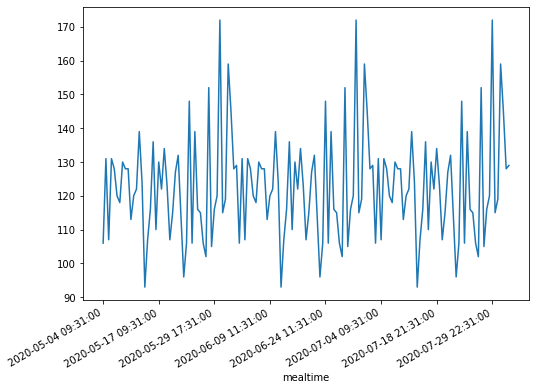

In [747]:
uni_data.plot(subplots=True)
#식사시간에 따른 

In [748]:
uni_data = uni_data.values

In [749]:
uni_train_mean = uni_data[:TRAIN_SPLIT].mean()
uni_train_std = uni_data[:TRAIN_SPLIT].std()

In [750]:
uni_data = (uni_data-uni_train_mean)/uni_train_std

In [753]:
#마지막 20개의 혈당기록을 데이터로 가지고 다음 혈당수치 예측하기
univariate_past_history = 20
univariate_future_target = 3

x_train_uni, y_train_uni = univariate_data(uni_data, 0, TRAIN_SPLIT,
                                           univariate_past_history,
                                           univariate_future_target-1)
x_val_uni, y_val_uni = univariate_data(uni_data, TRAIN_SPLIT, None,
                                       univariate_past_history,
                                       univariate_future_target)

In [754]:
print ('Single window of past history')
print (x_train_uni[0])
print ('\n Target glucose to predict')
print (y_train_uni[0])

Single window of past history
[[-1.03648711]
 [ 0.56105776]
 [-0.97258532]
 [ 0.56105776]
 [ 0.36935237]
 [-0.14186198]
 [-0.26966557]
 [ 0.49715596]
 [ 0.36935237]
 [ 0.36935237]
 [-0.58917455]
 [-0.14186198]
 [-0.01405839]
 [ 1.07227212]
 [ 0.11374519]
 [-1.86721044]
 [-0.97258532]
 [-0.39746916]
 [ 0.88056673]
 [-0.78087993]]

 Target glucose to predict
0.7527631416361686


In [755]:
#데이터 생성되었으므로 예측값 확인
def create_time_steps(length):
  return list(range(-length, 0))


In [756]:
def show_plot(plot_data, delta, title):
  labels = ['History', 'True Future', 'Model Prediction']
  marker = ['.-', 'rx', 'go']
  time_steps = create_time_steps(plot_data[0].shape[0])
  if delta:
    future = delta
  else:
    future = 0

  plt.title(title)
  for i, x in enumerate(plot_data):
    if i:
      plt.plot(future, plot_data[i], marker[i], markersize=10,
               label=labels[i])
    else:
      plt.plot(time_steps, plot_data[i].flatten(), marker[i], label=labels[i])
  plt.legend()
  plt.xlim([time_steps[0], (future+5)*2])
  plt.xlabel('Time-Step')
  return plt

<module 'matplotlib.pyplot' from 'C:\\Users\\qkrtm\\Anaconda3\\lib\\site-packages\\matplotlib\\pyplot.py'>

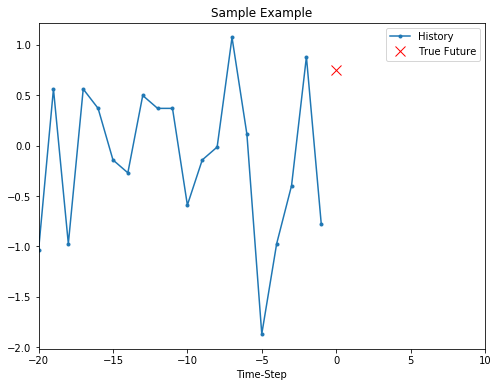

In [757]:
#올바른 예측 정답 값은 빨간 X
show_plot([x_train_uni[0], y_train_uni[0]], 0, 'Sample Example')

In [760]:
#베이스라인 = 입력지점 주어지면, 모든 기록의 다음 예측은 
#최근 20개의 관측치 평균으로 예측할 것(학습)

In [761]:
def baseline(history):
  return np.mean(history)

<module 'matplotlib.pyplot' from 'C:\\Users\\qkrtm\\Anaconda3\\lib\\site-packages\\matplotlib\\pyplot.py'>

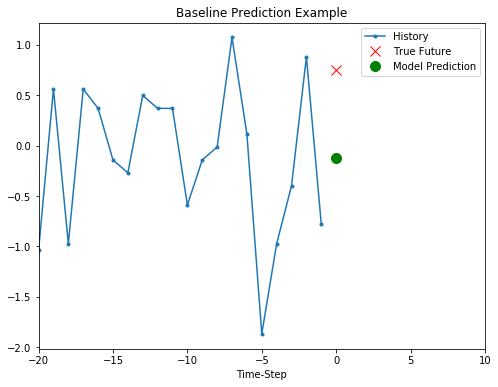

In [762]:
show_plot([x_train_uni[0], y_train_uni[0], baseline(x_train_uni[0])], 0,
           'Baseline Prediction Example')

In [763]:
#모델의 예측값이 정답 Y라벨을 생각보다 가깝게 잡아냄 혈당값만 가지고 예측한 상황

In [764]:
#이제 RNN사용
BATCH_SIZE = 256
BUFFER_SIZE = 10000

train_univariate = tf.data.Dataset.from_tensor_slices((x_train_uni, y_train_uni))
train_univariate = train_univariate.cache().shuffle(BUFFER_SIZE).batch(BATCH_SIZE).repeat()

val_univariate = tf.data.Dataset.from_tensor_slices((x_val_uni, y_val_uni))
val_univariate = val_univariate.batch(BATCH_SIZE).repeat()

In [765]:
simple_lstm_model = tf.keras.models.Sequential([
    tf.keras.layers.LSTM(8, input_shape=x_train_uni.shape[-2:]),
    tf.keras.layers.Dense(1)
])

simple_lstm_model.compile(optimizer='adam', loss='mae')

In [766]:
#옵티마이저는 아담, 손실함수는 mean abs를 사용

In [767]:
#모델 출력 확인을 위해 샘플 예측
for x, y in val_univariate.take(1):
    print(simple_lstm_model.predict(x).shape)

(74, 1)


In [768]:
#모델 훈련 시키기 simple lstm 모델
EVALUATION_INTERVAL = 200
EPOCHS = 10

#simple_lstm_model.fit(train_univariate, epochs=EPOCHS,
                   #   steps_per_epoch=EVALUATION_INTERVAL,
                    #  validation_data=val_univariate, validation_steps=50)
uni_history = simple_lstm_model.fit(train_univariate, epochs=EPOCHS,
                      steps_per_epoch=EVALUATION_INTERVAL,
                      validation_data=val_univariate, validation_steps=50)

Train for 200 steps, validate for 50 steps
Epoch 1/10
200/200 [==============================] - 4s 20ms/step - loss: 0.8731 - val_loss: 0.7830
Epoch 2/10
200/200 [==============================] - 2s 11ms/step - loss: 0.7532 - val_loss: 0.7867
Epoch 3/10
200/200 [==============================] - 2s 10ms/step - loss: 0.6484 - val_loss: 0.8184
Epoch 4/10
200/200 [==============================] - 2s 10ms/step - loss: 0.5909 - val_loss: 0.8391
Epoch 5/10
200/200 [==============================] - 2s 10ms/step - loss: 0.5391 - val_loss: 0.8964
Epoch 6/10
200/200 [==============================] - 2s 11ms/step - loss: 0.4677 - val_loss: 0.9432
Epoch 7/10
200/200 [==============================] - 2s 10ms/step - loss: 0.4162 - val_loss: 0.9779
Epoch 8/10
200/200 [==============================] - 2s 10ms/step - loss: 0.3546 - val_loss: 1.0218
Epoch 9/10
200/200 [==============================] - 2s 10ms/step - loss: 0.3092 - val_loss: 1.0964
Epoch 10/10
200/200 [===========================

In [769]:
#훈련 loss 는 0.0185, val loss 는 0.2974로 줄였다.
def plot_train_history(history, title):
  loss = history.history['loss']
  val_loss = history.history['val_loss']

  epochs = range(len(loss))

  plt.figure()

  plt.plot(epochs, loss, 'b', label='Training loss')
  plt.plot(epochs, val_loss, 'r', label='Validation loss')
  plt.title(title)
  plt.legend()

  plt.show()

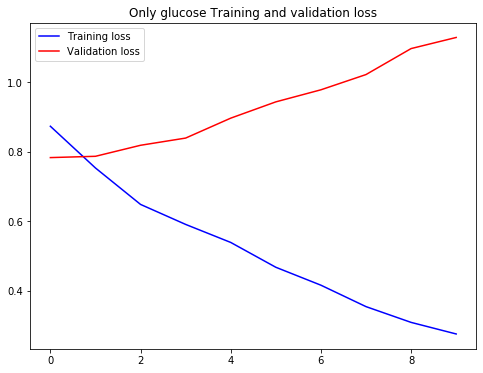

In [770]:
plot_train_history(uni_history,
                   'Only glucose Training and validation loss')

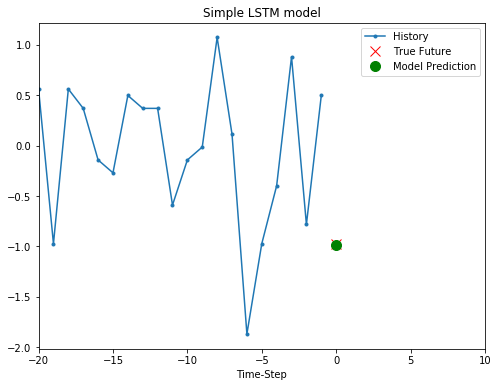

In [771]:
# 이 simple lstm 학습모델을 가지고 예측 시도
for x, y in val_univariate.take(1):
  plot = show_plot([x[0].numpy(), y[0].numpy(),
                    simple_lstm_model.predict(x)[6]], 0, 'Simple LSTM model')
  plot.show()

In [722]:
#하나의 혈당 값만 고려해서 학습하니 예측의 정확도 괜찮.

In [772]:
#UNI VARIATE 즉 혈당 값만으로 혈당값을 예측하는 것이기에 생각보다 잘 맞춘다.
#다변량 시계열 에측
#2시간 후의 혈당값을 다른 여러 값을 통해서 해보자
features_considered = ['meal(kcal)', 'after 2hours (mg/dL)', 'before(mg/dL)']

In [773]:
features = df[features_considered]
features.index = df['mealtime']
features.head(20)

,meal(kcal),after 2hours (mg/dL),before(mg/dL)
mealtime,,,
2020-05-04 09:31:00,340,106,110
2020-05-05 09:31:00,183,131,116
2020-05-06 09:31:00,171,107,111
2020-05-07 09:31:00,460,131,119
2020-05-07 12:31:00,1018,128,103
2020-05-08 09:31:00,363,120,108
2020-05-08 12:31:00,688,118,91
2020-05-09 09:31:00,280,130,114
2020-05-09 15:45:00,318,128,106


array([<matplotlib.axes._subplots.AxesSubplot object at 0x00000225787E4C08>,
      dtype=object)

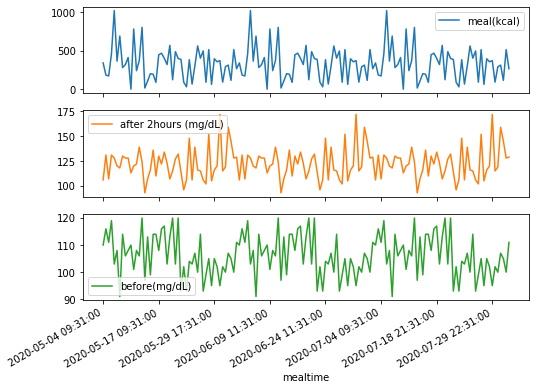

In [774]:
features.plot(subplots=True)
#  X 축 : 식사 시간 , Y축 각각  섭취음식, 식사칼로리, 측정 2시간 후 혈당

In [775]:
dataset = features.values
#data_mean = dataset[:TRAIN_SPLIT].mean(axis=0)
#data_std = dataset[:TRAIN_SPLIT].std(axis=0)

#dataset = (dataset-data_mean)/data_std

In [776]:
def multivariate_data(dataset, target, start_index, end_index, history_size,
                      target_size, step, single_step=False):
  data = []
  labels = []

  start_index = start_index + history_size
  if end_index is None:
    end_index = len(dataset) - target_size

  for i in range(start_index, end_index):
    indices = range(i-history_size, i, step)
    data.append(dataset[indices])

    if single_step:
      labels.append(target[i+target_size])
    else:
      labels.append(target[i:i+target_size])

  return np.array(data), np.array(labels)

In [791]:
#60개(20일 * 3개(끼니당)
#예측 레이블 (3일 * 3끼니 즉 미래 하루의 혈당 예측)
past_history = 48
future_target = 9
STEP = 3
x_train_single, y_train_single = multivariate_data(dataset, dataset[:, 1], 0,
                                                   TRAIN_SPLIT, past_history,
                                                   future_target, STEP,
                                                   single_step=True)
x_val_single, y_val_single = multivariate_data(dataset, dataset[:, 1],
                                               TRAIN_SPLIT, None, past_history,
                                               future_target, STEP,
                                               single_step=True)

In [792]:
print ('Single window of past history : {}'.format(x_train_single[0].shape))

Single window of past history : (16, 3)


In [793]:
train_data_single = tf.data.Dataset.from_tensor_slices((x_train_single, y_train_single))
train_data_single = train_data_single.cache().shuffle(BUFFER_SIZE).batch(BATCH_SIZE).repeat()

val_data_single = tf.data.Dataset.from_tensor_slices((x_val_single, y_val_single))
val_data_single = val_data_single.batch(BATCH_SIZE).repeat()

In [794]:
single_step_model = tf.keras.models.Sequential()
single_step_model.add(tf.keras.layers.LSTM(32,
                                           input_shape=x_train_single.shape[-2:]))
single_step_model.add(tf.keras.layers.Dense(1))

single_step_model.compile(optimizer=tf.keras.optimizers.RMSprop(), loss='mae')

In [795]:
#옵티마이저는 rmsprop으로 변경
for x, y in val_data_single.take(1):
  print(single_step_model.predict(x).shape)

(40, 1)


In [796]:
single_step_history = single_step_model.fit(train_data_single, epochs=EPOCHS,
                                            steps_per_epoch=EVALUATION_INTERVAL,
                                            validation_data=val_data_single,
                                            validation_steps=50)

Train for 200 steps, validate for 50 steps
Epoch 1/10
200/200 [==============================] - 3s 17ms/step - loss: 125.3860 - val_loss: 118.9971
Epoch 2/10
200/200 [==============================] - 2s 9ms/step - loss: 121.9193 - val_loss: 115.5549
Epoch 3/10
200/200 [==============================] - 2s 9ms/step - loss: 118.8917 - val_loss: 112.5980
Epoch 4/10
200/200 [==============================] - 2s 9ms/step - loss: 115.8913 - val_loss: 109.6842
Epoch 5/10
200/200 [==============================] - 2s 9ms/step - loss: 112.8913 - val_loss: 106.8109
Epoch 6/10
200/200 [==============================] - 2s 11ms/step - loss: 109.8912 - val_loss: 103.9410
Epoch 7/10
200/200 [==============================] - 2s 10ms/step - loss: 106.8911 - val_loss: 101.0727
Epoch 8/10
200/200 [==============================] - 2s 11ms/step - loss: 103.8909 - val_loss: 98.2051
Epoch 9/10
200/200 [==============================] - 2s 11ms/step - loss: 100.8908 - val_loss: 95.3381
Epoch 10/10
200/20

In [797]:
def plot_train_history(history, title):
  loss = history.history['loss']
  val_loss = history.history['val_loss']

  epochs = range(len(loss))

  plt.figure()

  plt.plot(epochs, loss, 'b', label='Training loss')
  plt.plot(epochs, val_loss, 'r', label='Validation loss')
  plt.title(title)
  plt.legend()

  plt.show()

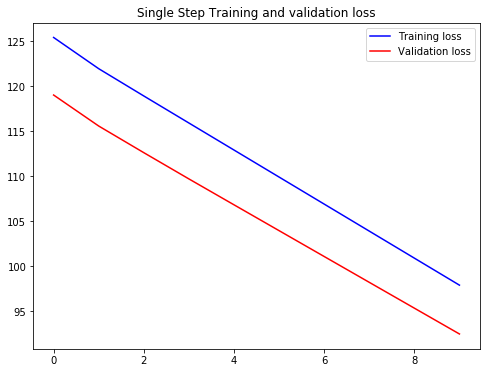

In [798]:
plot_train_history(single_step_history,
                   'Single Step Training and validation loss')

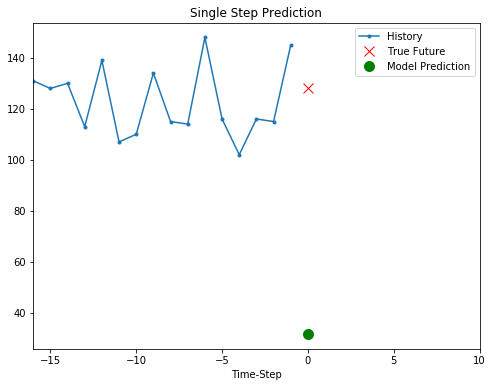

In [802]:
for x, y in val_data_single.take(1):
  plot = show_plot([x[0][:, 1].numpy(), y[0].numpy(),
                    single_step_model.predict(x)[0]], 0,
                   'Single Step Prediction')
  plot.show()

In [803]:
#과거 데이터를 가지고 미래 값을 예측
#3*(1일 3끼 = 9개의 식사 후 혈당 예측)
future_target = 9
x_train_multi, y_train_multi = multivariate_data(dataset, dataset[:, 1], 0,
                                                 TRAIN_SPLIT, past_history,
                                                 future_target, STEP)
x_val_multi, y_val_multi = multivariate_data(dataset, dataset[:, 1],
                                             TRAIN_SPLIT, None, past_history,
                                             future_target, STEP)

In [804]:
print ('Single window of past history : {}'.format(x_train_multi[0].shape))
print ('\n Target glucose to predict : {}'.format(y_train_multi[0].shape))

Single window of past history : (16, 3)

 Target glucose to predict : (9,)


In [805]:
train_data_multi = tf.data.Dataset.from_tensor_slices((x_train_multi, y_train_multi))
train_data_multi = train_data_multi.cache().shuffle(BUFFER_SIZE).batch(BATCH_SIZE).repeat()

val_data_multi = tf.data.Dataset.from_tensor_slices((x_val_multi, y_val_multi))
val_data_multi = val_data_multi.batch(BATCH_SIZE).repeat()

In [806]:
def multi_step_plot(history, true_future, prediction):
  plt.figure(figsize=(12, 6))
  num_in = create_time_steps(len(history))
  num_out = len(true_future)

  plt.plot(num_in, np.array(history[:, 1]), label='History')
  plt.plot(np.arange(num_out)/STEP, np.array(true_future), 'bo',
           label='True Future')
  if prediction.any():
    plt.plot(np.arange(num_out)/STEP, np.array(prediction), 'ro',
             label='Predicted Future')
  plt.legend(loc='upper left')
  plt.show()

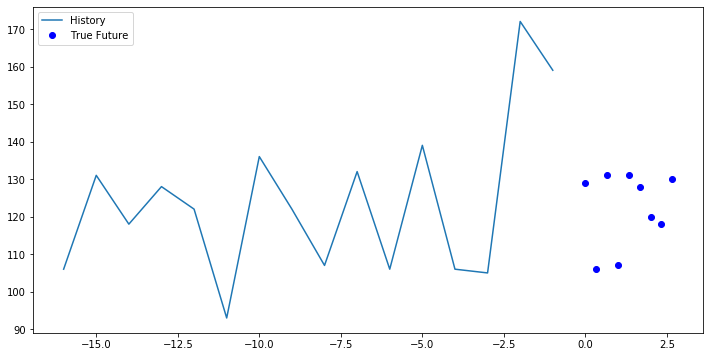

In [807]:
for x, y in train_data_multi.take(1):
  multi_step_plot(x[0], y[0], np.array([0]))
#정답인 Y레이블을 파란 점으로 표현

In [808]:
multi_step_model = tf.keras.models.Sequential()
multi_step_model.add(tf.keras.layers.LSTM(32,
                                          return_sequences=True,
                                          input_shape=x_train_multi.shape[-2:]))
multi_step_model.add(tf.keras.layers.LSTM(16, activation='relu'))
multi_step_model.add(tf.keras.layers.Dense(9))#디멘션 맞춰야한다.

multi_step_model.compile(optimizer=tf.keras.optimizers.RMSprop(clipvalue=1.0), loss='mae')

In [809]:
#좀더 DEEP한 2개 LAYER 사용, 72개 예측값 출력
for x, y in val_data_multi.take(1):
  print (multi_step_model.predict(x).shape)
#우선 SHAPE을 출력

(40, 9)


In [810]:
multi_step_history = multi_step_model.fit(train_data_multi, epochs=EPOCHS,
                                          steps_per_epoch=EVALUATION_INTERVAL,
                                          validation_data=val_data_multi,
                                          validation_steps=50)
#학습을 시켜본다.

Train for 200 steps, validate for 50 steps
Epoch 1/10
200/200 [==============================] - 5s 27ms/step - loss: 28.2868 - val_loss: 36.5947
Epoch 2/10
200/200 [==============================] - 3s 15ms/step - loss: 5.3843 - val_loss: 25.3157
Epoch 3/10
200/200 [==============================] - 3s 14ms/step - loss: 4.7939 - val_loss: 24.0596
Epoch 4/10
200/200 [==============================] - 3s 14ms/step - loss: 4.3459 - val_loss: 23.5622
Epoch 5/10
200/200 [==============================] - 3s 14ms/step - loss: 4.0653 - val_loss: 24.3322
Epoch 6/10
200/200 [==============================] - 3s 15ms/step - loss: 3.9159 - val_loss: 22.0917
Epoch 7/10
200/200 [==============================] - 3s 14ms/step - loss: 3.7792 - val_loss: 21.5637
Epoch 8/10
200/200 [==============================] - 3s 15ms/step - loss: 3.6050 - val_loss: 20.7404
Epoch 9/10
200/200 [==============================] - 3s 15ms/step - loss: 3.5787 - val_loss: 20.8231
Epoch 10/10
200/200 [=================

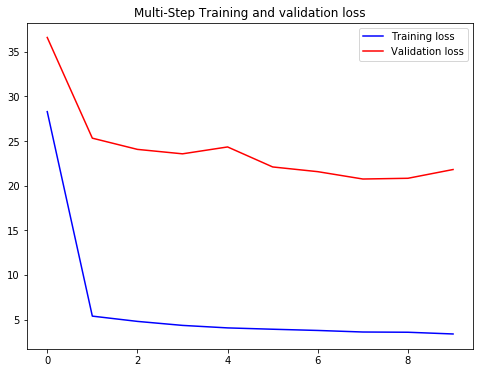

In [811]:
plot_train_history(multi_step_history, 'Multi-Step Training and validation loss')

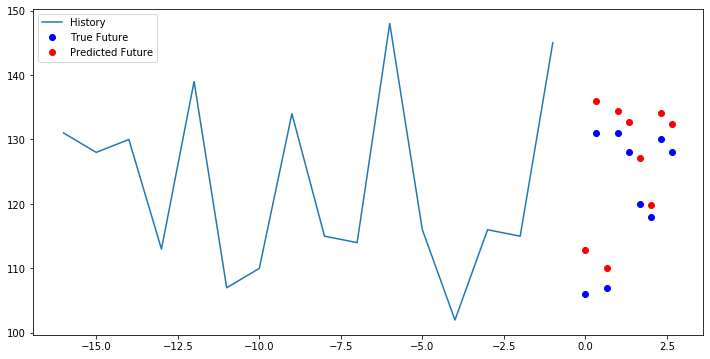

In [812]:
#학습된 네트워크가 미래예측을 잘 배웠는지 확인
#빨간 점이 예측값, 파란점이 실제 Y라벨
for x, y in val_data_multi.take(1):
  multi_step_plot(x[0], y[0], multi_step_model.predict(x)[0])